<a href="https://colab.research.google.com/github/chdmitr2/Deep-Learning-22961/blob/main/maman11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Broadcasted A:
tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])
Broadcasted B:
tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])
Passed all tests!


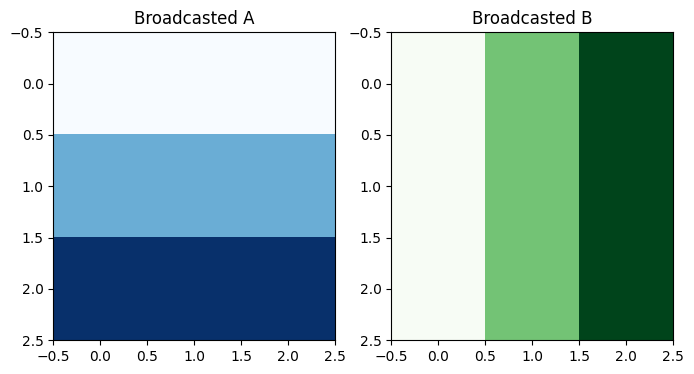

In [4]:
"""
Name: [Your Name]
ID: [Your ID]

Broadcasting Tensors in PyTorch
This script checks whether two tensors can be broadcasted together and performs broadcasting without using .expand() or .repeat().
"""

import torch
import matplotlib.pyplot as plt

def can_broadcast(shape_a, shape_b):
    """Checks if tensor of shape_a can be broadcasted to shape_b and returns the resulting shape."""
    rev_a, rev_b = shape_a[::-1], shape_b[::-1]
    target_shape = []

    for dim_a, dim_b in zip(rev_a, rev_b):
        if dim_a == dim_b:
            target_shape.append(dim_a)
        elif dim_a == 1:
            target_shape.append(dim_b)
        elif dim_b == 1:
            target_shape.append(dim_a)
        else:
            return False, None

    target_shape.extend(rev_b[len(rev_a):])
    return True, tuple(target_shape[::-1])

def expand_as(A, target_shape):
    """Expands tensor A to match the target shape without using .expand() or .repeat()."""
    original_shape = list(A.shape)
    num_dims = len(target_shape)

    # Add missing dimensions in front
    while len(original_shape) < num_dims:
        A = A.unsqueeze(0)
        original_shape.insert(0, 1)

    new_shape = []
    for i, (dim, target_dim) in enumerate(zip(original_shape, target_shape)):
        if dim == 1 and target_dim > 1:
            A = A.expand([*A.shape[:i], target_dim, *A.shape[i+1:]])  # Expand values
        new_shape.append(target_dim)

    return A

def broadcast_tensor(A, B):
    """Broadcasts tensor A to match the shape of tensor B."""
    can_bcast, target_shape = can_broadcast(A.shape, B.shape)
    if not can_bcast:
        raise ValueError("Cannot broadcast A to B's shape")

    return expand_as(A, target_shape)

def broadcast_tensors(A, B):
    """Broadcasts two tensors together following broadcasting rules."""
    can_bcast, target_shape = can_broadcast(A.shape, B.shape)
    if not can_bcast:
        raise ValueError("Cannot broadcast A and B together")

    return expand_as(A, target_shape), expand_as(B, target_shape)

# Example usage
A = torch.tensor([[1], [2], [3]])  # Shape (3,1)
B = torch.tensor([[1, 2, 3]])      # Shape (1,3)

broadcasted_A, broadcasted_B = broadcast_tensors(A, B)
print("Broadcasted A:")
print(broadcasted_A)
print("Broadcasted B:")
print(broadcasted_B)

# Validate against PyTorch broadcasting
A_pytorch, B_pytorch = torch.broadcast_tensors(A, B)
assert torch.allclose(broadcasted_A, A_pytorch)
assert torch.allclose(broadcasted_B, B_pytorch)
print("Passed all tests!")

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(broadcasted_A.numpy(), cmap='Blues', aspect='auto')
axs[0].set_title("Broadcasted A")
axs[1].imshow(broadcasted_B.numpy(), cmap='Greens', aspect='auto')
axs[1].set_title("Broadcasted B")
plt.show()